
# Analiza historycznych cen gier Steam w kontekście danych ekonomicznych World Bank



## Importowanie bibliotek i ładowanie danych

Poniżej importujemy wszystkie niezbędne biblioteki oraz ładujemy zbiory danych do analizy.


In [85]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [86]:

steam_df = pd.read_csv("steam_prices_1091500.csv")
macro_df = pd.read_csv("worldbank_data.csv")



## Ujednolicenie wszystkich cen do PLN (na podstawie twardo ustalonego kursu walut)

Poniższy słownik kursów walut został stworzony na podstawie wszystkich walut występujących w pliku z danymi.


In [87]:

currency_to_pln = {
    'AUD': 2.65,
    'BRL': 0.81,
    'CAD': 3.0,
    'CNY': 0.57,
    'EUR': 4.5,
    'INR': 0.049,
    'JPY': 0.027,
    'KRW': 0.0031,
    'MXN': 0.22,
    'PLN': 1.0,
    'USD': 4.1,
}

steam_df['exchange_rate'] = steam_df['currency'].map(currency_to_pln)
steam_df['price_pln'] = steam_df['price'] * steam_df['exchange_rate']

missing_currencies = steam_df.loc[steam_df['exchange_rate'].isnull(), 'currency'].unique()
if len(missing_currencies) > 0:
    print('Brakuje kursu dla:', ', '.join(missing_currencies))



## Wizualizacja: Rozkład cen gier w PLN

Histogram pokazuje rozkład wszystkich cen w PLN po przeliczeniu z oryginalnych walut.


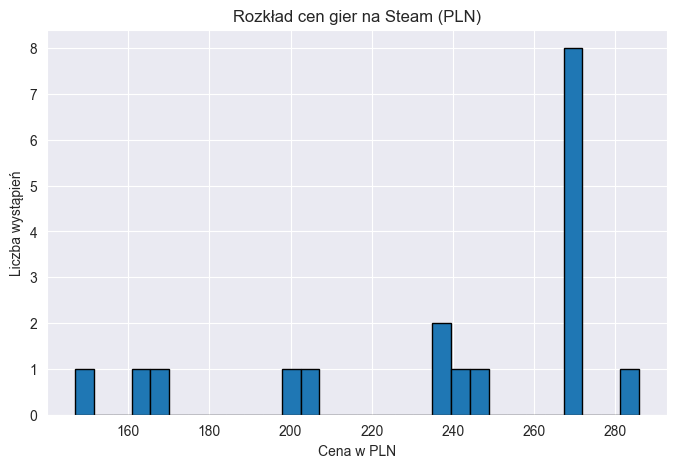

In [88]:

plt.figure(figsize=(8,5))
steam_df['price_pln'].dropna().hist(bins=30, edgecolor='black')
plt.title("Rozkład cen gier na Steam (PLN)")
plt.xlabel("Cena w PLN")
plt.ylabel("Liczba wystąpień")
plt.show()



## Średnia cena gry na Steam wg kraju (w PLN)

Poniżej wykres słupkowy przedstawiający średnią cenę gry (w złotówkach) w każdym kraju.


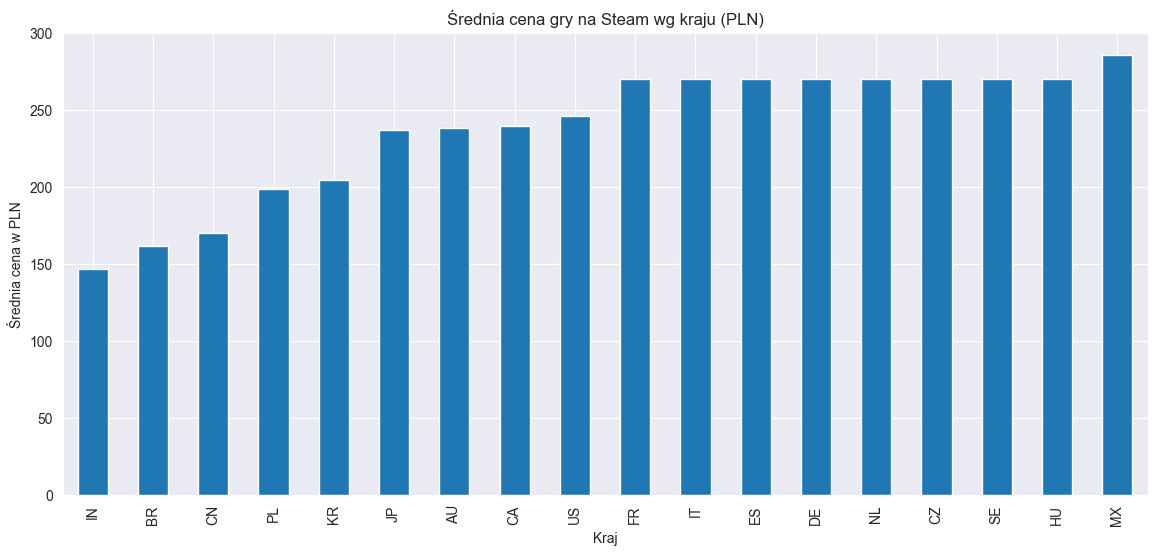

In [89]:

plt.figure(figsize=(14,6))
avg_price_pln_by_country = steam_df.groupby('country')['price_pln'].mean().sort_values()
avg_price_pln_by_country.plot(kind='bar')
plt.title("Średnia cena gry na Steam wg kraju (PLN)")
plt.ylabel("Średnia cena w PLN")
plt.xlabel("Kraj")
plt.show()



## Analiza korelacji pomiędzy wybranymi cechami

Heatmapa przedstawia siłę zależności (korelacji) pomiędzy różnymi cechami liczbowymi w danych ekonomicznych.


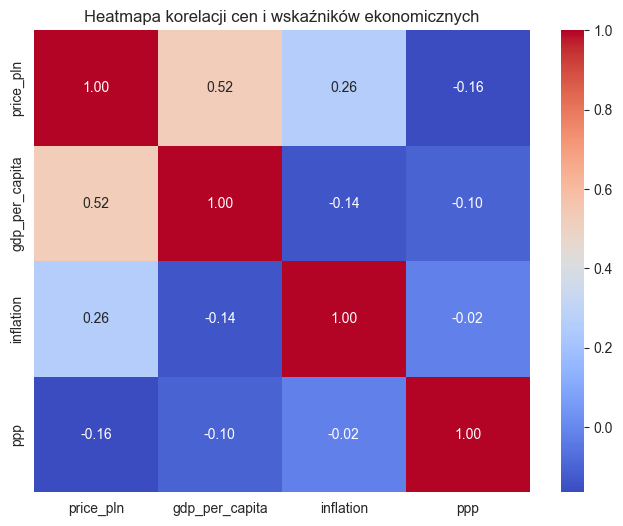

In [90]:

latest_year = macro_df['year'].max()
macro_latest = macro_df[macro_df['year'] == latest_year][['country', 'gdp_per_capita', 'inflation', 'ppp']]
merged = steam_df.merge(macro_latest, on='country', how='left')
corr = merged[['price_pln', 'gdp_per_capita', 'inflation', 'ppp']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Heatmapa korelacji cen i wskaźników ekonomicznych")
plt.show()


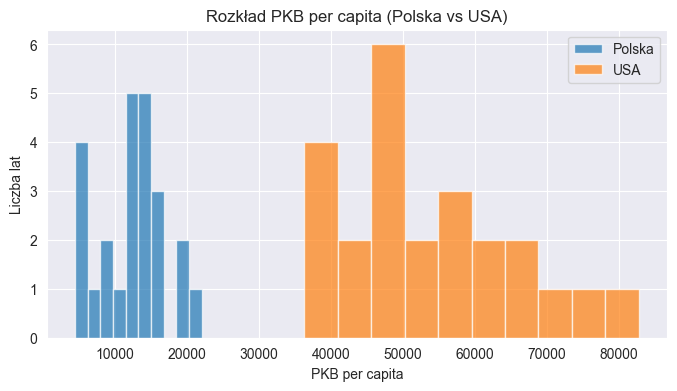

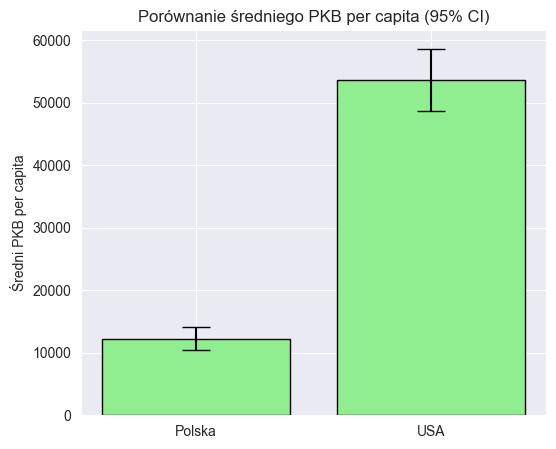

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

macro_df = pd.read_csv("worldbank_data.csv")

gdp_PL = macro_df[macro_df['country'] == 'PL']['gdp_per_capita'].dropna()
gdp_US = macro_df[macro_df['country'] == 'US']['gdp_per_capita'].dropna()

plt.figure(figsize=(8,4))
plt.hist(gdp_PL, bins=10, alpha=0.7, label="Polska")
plt.hist(gdp_US, bins=10, alpha=0.7, label="USA")
plt.xlabel("PKB per capita")
plt.ylabel("Liczba lat")
plt.title("Rozkład PKB per capita (Polska vs USA)")
plt.legend()
plt.show()

countries = ['Polska', 'USA']
means = [gdp_PL.mean(), gdp_US.mean()]
stds = [gdp_PL.std(), gdp_US.std()]
ns = [len(gdp_PL), len(gdp_US)]
cis = [1.96*std/np.sqrt(n) if n > 0 else 0 for std, n in zip(stds, ns)]

plt.figure(figsize=(6,5))
plt.bar(countries, means, yerr=cis, capsize=10, color='lightgreen', edgecolor='black')
plt.ylabel("Średni PKB per capita")
plt.title("Porównanie średniego PKB per capita (95% CI)")
plt.show()

t_stat, p_value = ttest_ind(gdp_PL, gdp_US, nan_policy='omit')


## Porównanie średniej inflacji i średniej ceny gry wg kraju

Wykres porównuje średnią inflację oraz średnią cenę gry (w PLN) w każdym kraju (tam gdzie dane są dostępne).


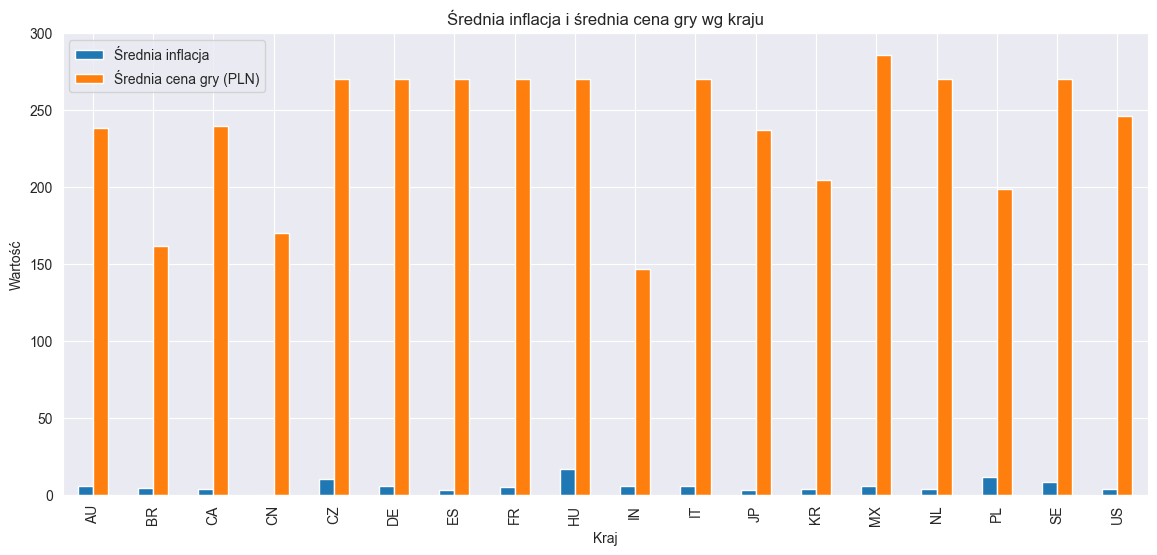

In [92]:

inflation_by_country = macro_latest.set_index('country')['inflation']
avg_price_by_country = steam_df.groupby('country')['price_pln'].mean()
comparison_df = pd.DataFrame({
    'inflation': inflation_by_country,
    'avg_price_pln': avg_price_by_country
}).dropna()
comparison_df.plot(kind='bar', figsize=(14,6))
plt.title("Średnia inflacja i średnia cena gry wg kraju")
plt.ylabel("Wartość")
plt.xlabel("Kraj")
plt.legend(["Średnia inflacja", "Średnia cena gry (PLN)"])
plt.show()



## Predykcja cen gier w przyszłości (regresja liniowa PySpark)

W tej sekcji budujemy model regresji liniowej w PySparku, który na podstawie danych ekonomicznych przewiduje przyszłą cenę gry (w PLN) dla danego kraju. Model uczy się na aktualnych danych, a jego wyniki przedstawione są na wykresie.


25/06/14 22:42:51 WARN Instrumentation: [68aff099] regParam is zero, which might cause numerical instability and overfitting.


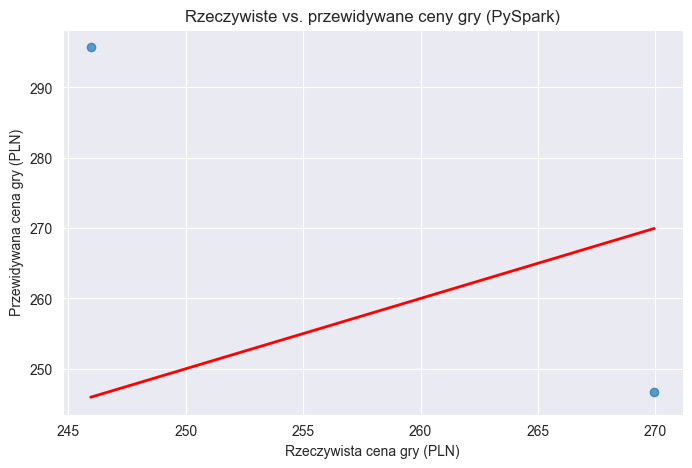

In [93]:

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder.master("local[*]").appName("SteamPricePrediction").getOrCreate()

feature_cols = ['gdp_per_capita', 'inflation', 'ppp']
temp = merged.dropna(subset=['price_pln'] + feature_cols)
spark_df = spark.createDataFrame(temp[['price_pln'] + feature_cols])

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
spark_df = assembler.transform(spark_df)

train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="price_pln")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="price_pln", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

pandas_pred = predictions.select("price_pln", "prediction").toPandas()
plt.figure(figsize=(8,5))
plt.scatter(pandas_pred['price_pln'], pandas_pred['prediction'], alpha=0.7)
plt.xlabel("Rzeczywista cena gry (PLN)")
plt.ylabel("Przewidywana cena gry (PLN)")
plt.title("Rzeczywiste vs. przewidywane ceny gry (PySpark)")
plt.plot([pandas_pred['price_pln'].min(), pandas_pred['price_pln'].max()],
         [pandas_pred['price_pln'].min(), pandas_pred['price_pln'].max()], color='red', lw=2)
plt.show()



## Prognoza cen gier na lata 2024–2040 dla wybranych krajów (PySpark)

Poniżej przedstawiamy prognozowane ceny gier (w PLN) do 2040 roku dla wybranych krajów, korzystając z modelu regresji liniowej PySpark. Zakładamy liniowy wzrost PKB (2% rocznie), wzrost inflacji (0.1 punktu procentowego rocznie), a PPP pozostaje stałe.


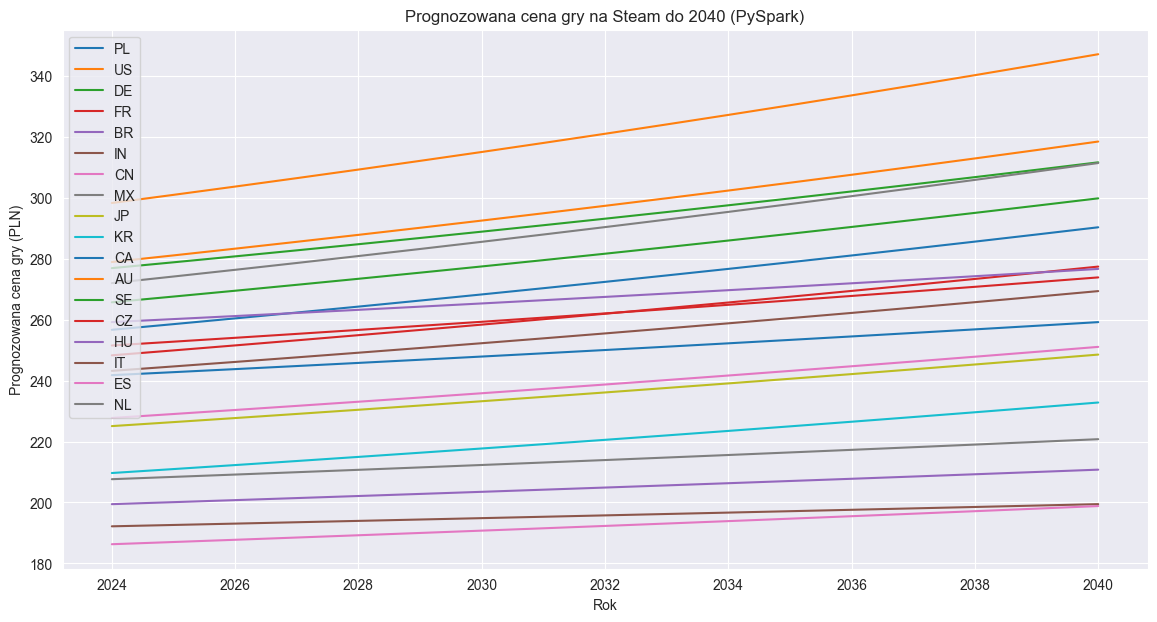

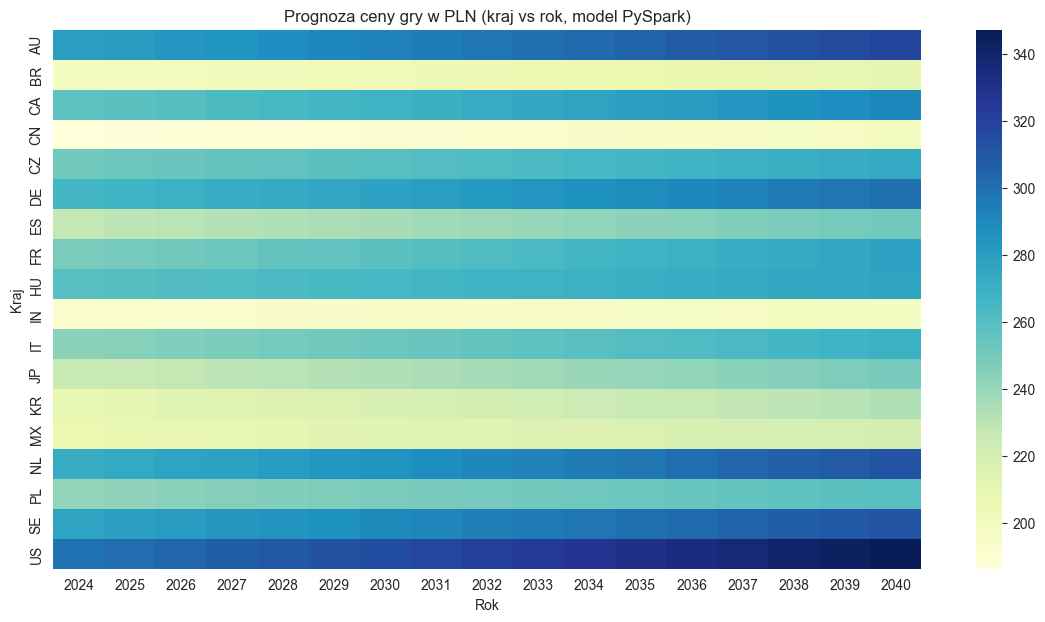

In [94]:

COUNTRIES = ['PL', 'US', 'DE', 'FR', 'BR', 'IN', 'CN', 'MX', 'JP', 'KR', 'CA', 'AU', 'SE', 'CZ', 'HU', 'IT', 'ES', 'NL']
future_years = list(range(2024, 2041))

macro_last = macro_df.sort_values('year').groupby('country').tail(1).set_index('country')

future_rows = []
for country in COUNTRIES:
    if country in macro_last.index:
        last = macro_last.loc[country]
        gdp = last['gdp_per_capita']
        infl = last['inflation']
        ppp = last['ppp']
        for year in future_years:
            years_diff = year - last['year']
            gdp_proj = gdp * (1.02 ** years_diff)
            infl_proj = infl + 0.1 * years_diff
            ppp_proj = ppp
            future_rows.append({
                'country': country,
                'year': year,
                'gdp_per_capita': gdp_proj,
                'inflation': infl_proj,
                'ppp': ppp_proj
            })
future_df = pd.DataFrame(future_rows)
future_df.reset_index(drop=True, inplace=True)

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['gdp_per_capita', 'inflation', 'ppp'], outputCol="features")
future_spark = spark.createDataFrame(future_df)
future_spark = assembler.transform(future_spark)

future_predictions = lr_model.transform(future_spark)
pred_prices = future_predictions.select("country", "year", "prediction").toPandas()

import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
for country in COUNTRIES:
    data = pred_prices[pred_prices['country'] == country]
    plt.plot(data['year'], data['prediction'], label=country)
plt.xlabel("Rok")
plt.ylabel("Prognozowana cena gry (PLN)")
plt.title("Prognozowana cena gry na Steam do 2040 (PySpark)")
plt.legend()
plt.show()

import seaborn as sns
heatmap_data = pred_prices.pivot(index='country', columns='year', values='prediction')
plt.figure(figsize=(14,7))
sns.heatmap(heatmap_data, annot=False, cmap="YlGnBu")
plt.title("Prognoza ceny gry w PLN (kraj vs rok, model PySpark)")
plt.xlabel("Rok")
plt.ylabel("Kraj")
plt.show()
